In [1]:
import sys
sys.path.append("../") 

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, data_home='../data',cache=True,as_frame=False)
X=X/255.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

In [4]:
import numpy as np
from hamiltonian import utils

num_examples,num_inputs=X_train.shape
num_outputs=len(np.unique(y_train))

#y_train=utils.one_hot(y_train,num_outputs)
#y_test=utils.one_hot(y_test,num_outputs)

In [5]:
y_train=np.int32(y_train)
y_test=np.int32(y_test)

In [6]:
import mxnet as mx
from mxnet import nd, autograd, gluon


model_ctx=mx.gpu()
par={'weights':nd.random_normal(shape=(num_inputs,num_outputs),ctx=model_ctx),'bias':nd.random_normal(shape=num_outputs,ctx=model_ctx)}
hyper={'alpha':10.}


# Stochastic Gradient Descent

In [221]:
from hamiltonian.inference.sgd import sgd
from hamiltonian.models.softmax import softmax

model=softmax(hyper,ctx=model_ctx)
inference=sgd(model,par,step_size=0.05,ctx=model_ctx)

In [218]:
import importlib
import hamiltonian
importlib.reload(hamiltonian.models.softmax)
importlib.reload(hamiltonian.inference.sgd)

<module 'hamiltonian.inference.sgd' from '../hamiltonian/inference/sgd.py'>

In [219]:
par,loss=inference.fit(epochs=10,batch_size=64,X_train=X_train,y_train=y_train,verbose=False)

100%|██████████| 10/10 [00:44<00:00,  4.49s/it]


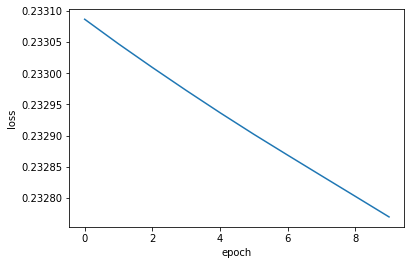

In [223]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [15]:
y_pred=model.predict(par,nd.array(X_test,ctx=model_ctx))

In [16]:
samples=[]
for _ in range(100):
    samples.append(y_pred.sample().asnumpy())

In [17]:
samples=np.asarray(samples)

In [18]:
samples.shape

(100, 14000)

In [19]:
y_hat=np.quantile(samples,.5,axis=0)

In [20]:
from sklearn.metrics import classification_report

print(classification_report(np.int32(y_test),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95      1431
           1       0.97      0.93      0.95      1532
           2       0.90      0.90      0.90      1376
           3       0.91      0.87      0.89      1385
           4       0.88      0.94      0.91      1339
           5       0.85      0.86      0.85      1298
           6       0.93      0.94      0.94      1416
           7       0.90      0.93      0.92      1473
           8       0.73      0.92      0.82      1351
           9       0.94      0.74      0.83      1399

    accuracy                           0.90     14000
   macro avg       0.90      0.90      0.90     14000
weighted avg       0.90      0.90      0.90     14000



In [21]:
X_batch=nd.array(X_train[:32],ctx=model_ctx)
y_batch=nd.array(y_train[:32],ctx=model_ctx)

In [22]:
like=model.negative_log_likelihood(par,X_train=X_batch,y_train=y_batch)
prior=model.negative_log_prior(par)

# Stochastic Gradient Langevin Dynamics

In [86]:
par={'weights':nd.random_normal(shape=(num_inputs,num_outputs),ctx=model_ctx),
     'bias':nd.random_normal(shape=num_outputs,ctx=model_ctx)}
hyper={'alpha':10.}

In [87]:
from hamiltonian.inference.sgld import sgld
from hamiltonian.models.softmax import softmax

model=softmax(hyper,ctx=model_ctx)
inference=sgld(model,par,step_size=0.05,ctx=model_ctx)

In [88]:
import importlib
import hamiltonian
importlib.reload(hamiltonian.models.softmax)
importlib.reload(hamiltonian.inference.sgld)

<module 'hamiltonian.inference.sgld' from '../hamiltonian/inference/sgld.py'>

In [89]:
par,loss=inference.fit(epochs=10,batch_size=64,
                             X_train=X_train,y_train=y_train,
                             verbose=True)

 10%|█         | 1/10 [00:05<00:51,  5.67s/it]

loss: 0.0860


 20%|██        | 2/10 [00:11<00:45,  5.68s/it]

loss: 0.0843


 30%|███       | 3/10 [00:16<00:39,  5.61s/it]

loss: 0.0849


 40%|████      | 4/10 [00:22<00:33,  5.62s/it]

loss: 0.0855


 50%|█████     | 5/10 [00:28<00:28,  5.73s/it]

loss: 0.0859


 60%|██████    | 6/10 [00:34<00:22,  5.72s/it]

loss: 0.0864


 70%|███████   | 7/10 [00:40<00:17,  5.78s/it]

loss: 0.0870


 80%|████████  | 8/10 [00:45<00:11,  5.73s/it]

loss: 0.0870


 90%|█████████ | 9/10 [00:50<00:05,  5.60s/it]

loss: 0.0874


100%|██████████| 10/10 [00:56<00:00,  5.66s/it]

loss: 0.0878


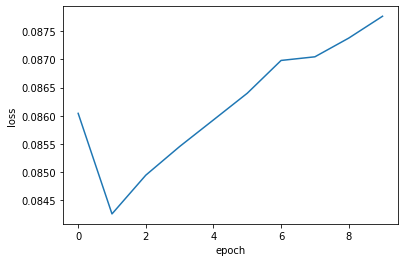

In [90]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [91]:
y_pred=model.predict(par,nd.array(X_test,ctx=model_ctx))

In [92]:
from sklearn.metrics import classification_report

samples=[]
for _ in range(100):
    samples.append(y_pred.sample().asnumpy())
samples=np.asarray(samples)
y_hat=np.quantile(samples,.5,axis=0)

print(classification_report(np.int32(y_test),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1370
           1       0.96      0.92      0.94      1531
           2       0.86      0.85      0.85      1402
           3       0.86      0.81      0.83      1461
           4       0.85      0.90      0.87      1337
           5       0.78      0.78      0.78      1288
           6       0.91      0.91      0.91      1385
           7       0.90      0.88      0.89      1451
           8       0.75      0.84      0.79      1361
           9       0.84      0.82      0.83      1414

    accuracy                           0.86     14000
   macro avg       0.86      0.86      0.86     14000
weighted avg       0.87      0.86      0.86     14000

